In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Transforming data to DateTime

In [2]:
fuelPrice = pd.read_csv('C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/1.csv', header = None, delimiter = ';', names = ('Time', 'Price'))
index = pd.DatetimeIndex(fuelPrice.Time)
fuelPrice.drop('Time', axis = 1, inplace = True)
fuelPrice.set_index(index, inplace = True)
fuelPrice = fuelPrice['2016':'2017']

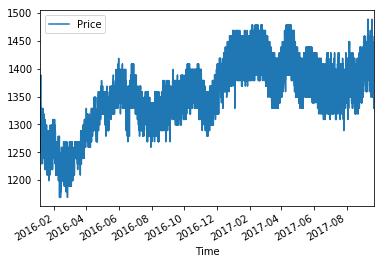

In [3]:
fuelPrice.plot()
plt.show()

# Resample by hour


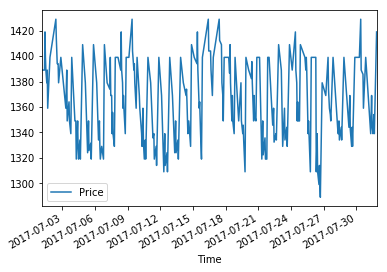

In [4]:
hour_fuelPrice = fuelPrice.resample('H').mean()
hour_fuelPrice.dropna(inplace = True)
hour_fuelPrice['2017-07'].plot()
plt.show()

# Check stationarity using augmented Dickey-Fuller test


In [5]:
def adftest(X):
    test = adfuller(X.iloc[:,0].values)

    print('Test Statistic: ',test[0])
    print('p-value: ',test[1])
    print('Lags: ',test[2])
    print('Observation number: ',test[3])
    print('Critical value 1%: ',test[4]['1%'])
    print('Critical value 5%: ',test[4]['5%'])
    print('Critical value 10%: ',test[4]['10%'])
    #print('Test Statistic: {};{}p-value: {};{}Lags: {};{}Observation number: {};'.format(test[0], '\n', test[1], '\n', test[2], '\n', test[3]))
    #print('Critical value 1%: {};{} Critical value 5%: {};{} Critical value 10% : {}'.format(test[4]['1%'], '\n', test[4]['5%'], '\n', test[4]['10%']))
    if (test[0]>test[4]['1%']) & (test[1]>0.05):
        print ('Time series is not stationary.')
    else:
        print('According to ADF time series is stationary.')
    return

In [6]:
adftest(hour_fuelPrice)

Test Statistic:  -2.45282595901
p-value:  0.127378090226
Lags:  24
Observation number:  4203
Critical value 1%:  -3.43190681616
Critical value 5%:  -2.86222791569
Critical value 10%:  -2.56713618328
Time series is not stationary.


# Decompose time series


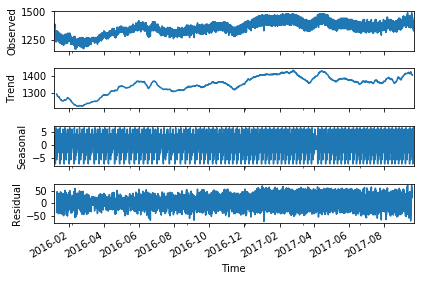

In [7]:
dec = sm.tsa.seasonal_decompose(hour_fuelPrice.interpolate(), freq = 50, model = 'additive')
dec.plot()
plt.show()

# Non-linear log transformation

In [8]:
hour_fuelPrice_log = np.log(hour_fuelPrice)
adftest(hour_fuelPrice_log)

Test Statistic:  -2.41383704115
p-value:  0.137869031146
Lags:  24
Observation number:  4203
Critical value 1%:  -3.43190681616
Critical value 5%:  -2.86222791569
Critical value 10%:  -2.56713618328
Time series is not stationary.


# Differencing

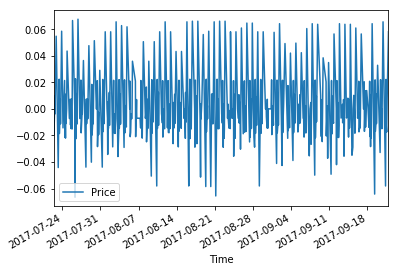

In [9]:
diff = hour_fuelPrice_log - hour_fuelPrice_log.shift()
diff.tail(500).plot()
plt.show()

In [10]:
diff.dropna(inplace = True)
adftest(diff)

Test Statistic:  -16.501281682
p-value:  2.14746181307e-29
Lags:  31
Observation number:  4195
Critical value 1%:  -3.43190978688
Critical value 5%:  -2.86222922803
Critical value 10%:  -2.56713688191
According to ADF time series is stationary.


# Model

In [42]:
mod = sm.tsa.statespace.SARIMAX(hour_fuelPrice_log, order = (4,1,0), seasonal_order=(1,1,0,12))
modf = mod.fit(disp = 0)
modf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 4228
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 12)   Log Likelihood                9127.309
Date:                            Tue, 28 Nov 2017   AIC                         -18242.618
Time:                                    09:02:11   BIC                         -18204.521
Sample:                                01-04-2016   HQIC                        -18229.152
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4573      0.016    -27.782      0.000      -0.490      -0.425
ar.L2         -0.3739      0.016    -23.075      0.000      -0.406      -0.342
ar.L3         -0.3168      0.016    -19.652      0.000      -0.348      -0.285
ar.L4         -0.2703      0.015    -18.036      0.000      -0.300      -0.241
ar.S.L12      -0.5070      0.013    -38.901      0.000      -0.533      -0.481
sigma2         0.0008    1.7e-05     45.139      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                     1340.35   Jarque-Bera (JB):                47.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

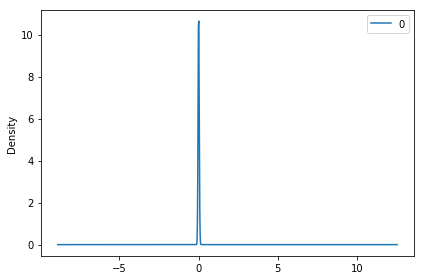

In [43]:
residuals = pd.DataFrame(modf.resid)
residuals.plot(kind='kde')
plt.tight_layout()
plt.show()

In [44]:
residuals.describe()

,0
count,4228.000000
mean,0.000850
std,0.126160
min,-3.537974
25%,-0.019121
50%,-0.001452
75%,0.016906
max,7.177019


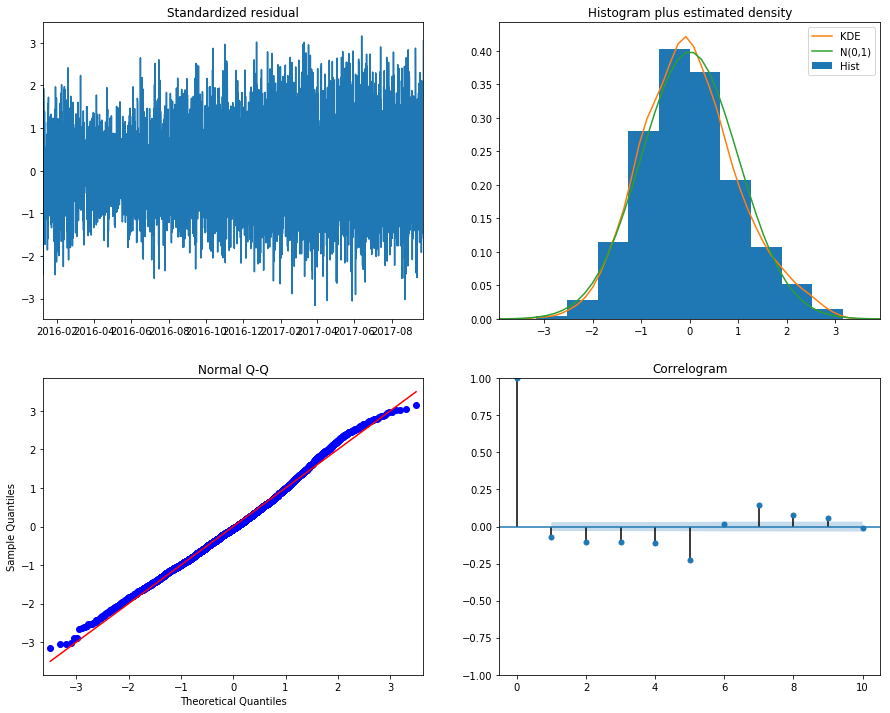

In [48]:
modf.plot_diagnostics(figsize=(15, 12))

# In-sample prediction

In [14]:
t = hour_fuelPrice_log.as_matrix()
size = int(len(t) - 15)
train,  test = t[0:size], t[size:len(t)]
log = [x for x in train]
predictions = list()
print('Predicted vs Expected:')
for t in range(len(test)):
    mod = sm.tsa.statespace.SARIMAX(log, order = (4,1,0), seasonal_order=(4,1,0,12)).fit(disp = 0)
    res = mod.forecast()
    yhat = res[0]
    predictions.append(float(yhat))
    obs = test[t]
    log.append(obs)
    print('predicted=%.2f, expected=%.2f' % (np.exp(yhat), np.exp(obs)))


Predicted vs Expected:
predicted=1356.11, expected=1349.00
predicted=1362.64, expected=1394.00
predicted=1391.87, expected=1349.00
predicted=1335.11, expected=1379.00
predicted=1362.26, expected=1364.00
predicted=1357.78, expected=1349.00
predicted=1343.35, expected=1349.00
predicted=1361.34, expected=1329.00
predicted=1345.90, expected=1419.00
predicted=1403.52, expected=1339.00
predicted=1350.25, expected=1369.00
predicted=1357.93, expected=1352.33
predicted=1345.83, expected=1329.00
predicted=1341.02, expected=1339.00
predicted=1315.54, expected=1419.00


In [20]:
mean_squared_error(test, predictions)

0.00095468654423473296

In [36]:
H = 20
mod = sm.tsa.statespace.SARIMAX(hour_fuelPrice, order = (4,1,0), seasonal_order=(4,1,0,8)).fit(disp = 0)
forecasty = mod.forecast(steps = H)
index = pd.date_range(hour_fuelPrice.index[-1], periods = H, freq = 'H')
forecasted_price = pd.DataFrame(forecasty[0], index = index)
hour_fuelPrice = hour_fuelPrice.append(forecasted_price)

In [37]:
print(hour_fuelPrice.tail(H+30))

                           Price            0
2017-09-18 05:00:00  1449.000000          NaN
2017-09-18 07:00:00  1429.000000          NaN
2017-09-18 10:00:00  1459.000000          NaN
2017-09-18 11:00:00  1429.000000          NaN
2017-09-18 13:00:00  1429.000000          NaN
2017-09-18 14:00:00  1389.000000          NaN
2017-09-18 15:00:00  1404.000000          NaN
2017-09-18 16:00:00  1389.000000          NaN
2017-09-18 17:00:00  1359.000000          NaN
2017-09-18 21:00:00  1449.000000          NaN
2017-09-19 08:00:00  1359.000000          NaN
2017-09-19 10:00:00  1389.000000          NaN
2017-09-19 11:00:00  1365.666667          NaN
2017-09-19 13:00:00  1349.000000          NaN
2017-09-19 15:00:00  1364.000000          NaN
2017-09-19 16:00:00  1349.000000          NaN
2017-09-19 21:00:00  1394.000000          NaN
2017-09-20 08:00:00  1349.000000          NaN
2017-09-20 10:00:00  1379.000000          NaN
2017-09-20 11:00:00  1364.000000          NaN
2017-09-20 14:00:00  1349.000000  

In [ ]:
hour_fuelPrice.tail(H+30).plot()
plt.show()